In [1]:
import os, torch, librosa, sklearn, librosa.display, glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import Audio
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

random_state = np.random.RandomState(0)

data_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data'
genres=(list(os.listdir(f'{data_path}/genres_original/')))

# Alphabetize the list of genres
sorted_genres = sorted(genres)

# Create a dictionary with genres as keys and values from 0 to n-1
genre_dict = {genre: index for index, genre in enumerate(sorted_genres)}
print(genre_dict)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [2]:
# clear outputs in kaggle
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)

In [3]:
# Transforming audio files into Mel spectrograms and saving

print("Transforming the Audio Files into Mel Spectrograms:")
batch_size = 32

hop_length = 512
forbidden = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav'
mel_spectogram_data = {}
for genre in genre_dict.keys():
    
    mel_spectogram_data[genre] = []
    for name in glob.glob(data_path + "/genres_original/" + genre + "/*"):
        if name != forbidden:
            data,sampling_rate = librosa.load(name)
            sgram = librosa.stft(data) # Regular spectrogram
            magphase, _ = librosa.magphase(sgram) #decompose magnitude and phase from spectrogram
            mel_spec = librosa.feature.melspectrogram(S=magphase, sr=sampling_rate,hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

            mel_spectogram_data[genre].append(mel_spec_db)



Transforming the Audio Files into Mel Spectrograms:


In [4]:
print("Saving the Mel Spectrogram Images:")
plt.ioff()           
x = []
y = []
for genre in genre_dict.keys():

   
    for i in range(len(mel_spectogram_data[genre])):
        plt.figure(figsize=(16, 6))

        img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool', y_axis='mel', fmax=8000, x_axis='time')
        image_path = genre + "_" + str(i) + ".png"
        x.append(image_path)
        y.append(genre)
        if not os.path.exists(image_path):
            plt.savefig(image_path)
        plt.close()
df = pd.DataFrame({'image_path': x, 'genre': y})

Saving the Mel Spectrogram Images:


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the data
x_train, x_test, y_train, y_test = train_test_split(df['image_path'], df['genre'], test_size=0.3, random_state=0)

# Create a new DataFrame for training data and testing data
train_df = pd.DataFrame({'image_path': x_train, 'genre': y_train})
test_df = pd.DataFrame({'image_path': x_test, 'genre': y_test})

# Create ImageDataGenerators
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create the training set
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='genre',
    target_size=(224, 224),  # Adjusted size
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='genre',
    target_size=(224, 224),  # Adjusted size
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

Found 699 validated image filenames belonging to 10 classes.
Found 300 validated image filenames belonging to 10 classes.


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Flatten, Dense
input_shape=(224, 224, 3)

# build network topology

model = Sequential()
model.add(Conv2D(32, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

In [7]:
hist = model.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)

Epoch 1/20
22/22 [==============================] - 62s 3s/step - loss: 3.2371 - accuracy: 0.1102 - val_loss: 2.2350 - val_accuracy: 0.1533
Epoch 2/20
22/22 [==============================] - 36s 2s/step - loss: 2.2083 - accuracy: 0.2003 - val_loss: 2.1391 - val_accuracy: 0.2467
Epoch 3/20
22/22 [==============================] - 36s 2s/step - loss: 2.0878 - accuracy: 0.2489 - val_loss: 2.1808 - val_accuracy: 0.2533
Epoch 4/20
22/22 [==============================] - 36s 2s/step - loss: 2.0238 - accuracy: 0.2761 - val_loss: 2.0242 - val_accuracy: 0.3000
Epoch 5/20
22/22 [==============================] - 36s 2s/step - loss: 1.8921 - accuracy: 0.3047 - val_loss: 1.9282 - val_accuracy: 0.3133
Epoch 6/20
22/22 [==============================] - 36s 2s/step - loss: 1.8244 - accuracy: 0.3391 - val_loss: 1.8365 - val_accuracy: 0.3300
Epoch 7/20
22/22 [==============================] - 36s 2s/step - loss: 1.8004 - accuracy: 0.3476 - val_loss: 1.8384 - val_accuracy: 0.2933
Epoch 8/20
22/22 [==

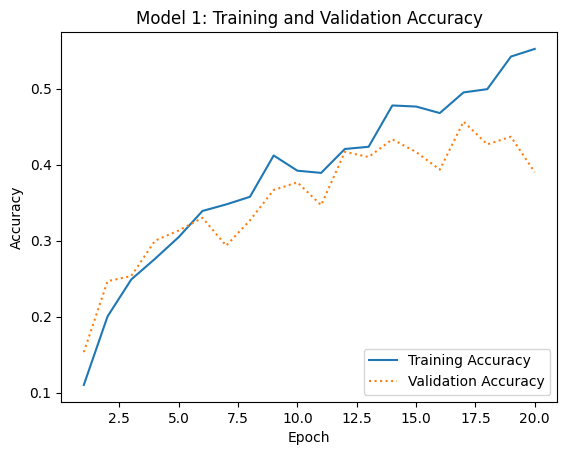

In [8]:
# Display results
def display_results(hist, name):
    plt.ion()  
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title(name + ': Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    plt.show()
display_results(hist, "Model 1")

Epoch 1/20
22/22 [==============================] - 36s 2s/step - loss: 5.6648 - accuracy: 0.1059 - val_loss: 2.3684 - val_accuracy: 0.1167
Epoch 2/20
22/22 [==============================] - 33s 2s/step - loss: 2.2175 - accuracy: 0.1760 - val_loss: 2.2218 - val_accuracy: 0.1733
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 2.0806 - accuracy: 0.2346 - val_loss: 2.0482 - val_accuracy: 0.2700
Epoch 4/20
22/22 [==============================] - 33s 2s/step - loss: 1.9943 - accuracy: 0.2718 - val_loss: 1.9881 - val_accuracy: 0.2800
Epoch 5/20
22/22 [==============================] - 33s 2s/step - loss: 1.8864 - accuracy: 0.3133 - val_loss: 1.9550 - val_accuracy: 0.2833
Epoch 6/20
22/22 [==============================] - 33s 2s/step - loss: 1.8630 - accuracy: 0.3290 - val_loss: 1.9176 - val_accuracy: 0.3000
Epoch 7/20
22/22 [==============================] - 33s 2s/step - loss: 1.7662 - accuracy: 0.3319 - val_loss: 1.8106 - val_accuracy: 0.3300
Epoch 8/20
22/22 [==

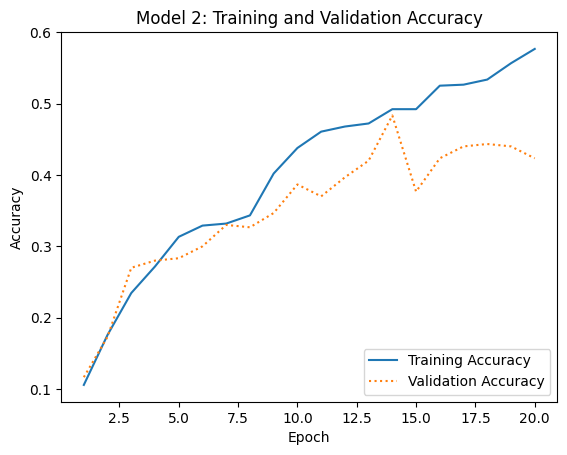

In [10]:
# Model 2: Change Convolution layer parameters

model2 = Sequential()
model2.add(Conv2D(8, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))

model2.add(Flatten())
model2.add(Dense(64, activation= 'relu'))
model2.add(Dense(10, activation= 'softmax'))

model2.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])
hist = model2.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)
display_results(hist, "Model 2")

Epoch 1/20
22/22 [==============================] - 36s 2s/step - loss: 2.1927 - accuracy: 0.2332 - val_loss: 9.0319 - val_accuracy: 0.0733
Epoch 2/20
22/22 [==============================] - 33s 1s/step - loss: 1.8844 - accuracy: 0.3391 - val_loss: 6.1102 - val_accuracy: 0.0733
Epoch 3/20
22/22 [==============================] - 33s 2s/step - loss: 1.6861 - accuracy: 0.4406 - val_loss: 4.3224 - val_accuracy: 0.1600
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 1.5257 - accuracy: 0.4793 - val_loss: 5.0142 - val_accuracy: 0.1800
Epoch 5/20
22/22 [==============================] - 33s 1s/step - loss: 1.5619 - accuracy: 0.4578 - val_loss: 8.6953 - val_accuracy: 0.1033
Epoch 6/20
22/22 [==============================] - 33s 1s/step - loss: 1.4148 - accuracy: 0.4979 - val_loss: 3.8601 - val_accuracy: 0.2133
Epoch 7/20
22/22 [==============================] - 32s 1s/step - loss: 1.2322 - accuracy: 0.5722 - val_loss: 3.3109 - val_accuracy: 0.2367
Epoch 8/20
22/22 [==

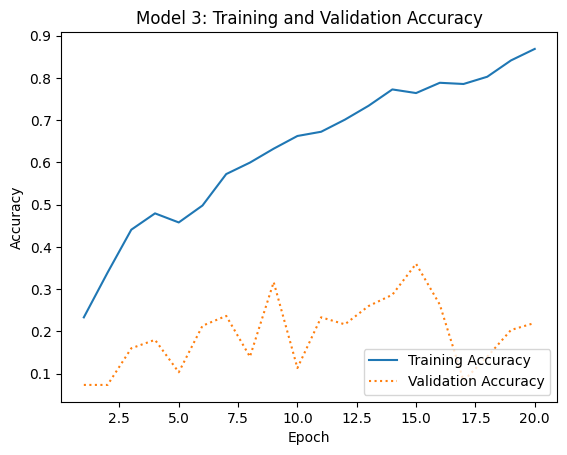

In [12]:
# Batch Normalization and Dropout - Model 3
model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])
hist = model.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)
display_results(hist, "Model 3")

Epoch 1/20
22/22 [==============================] - 35s 2s/step - loss: 2.8730 - accuracy: 0.0959 - val_loss: 2.3371 - val_accuracy: 0.1167
Epoch 2/20
22/22 [==============================] - 32s 1s/step - loss: 2.2323 - accuracy: 0.1803 - val_loss: 2.1274 - val_accuracy: 0.1533
Epoch 3/20
22/22 [==============================] - 32s 1s/step - loss: 2.0529 - accuracy: 0.2647 - val_loss: 2.0343 - val_accuracy: 0.2067
Epoch 4/20
22/22 [==============================] - 32s 1s/step - loss: 1.9332 - accuracy: 0.2847 - val_loss: 2.0010 - val_accuracy: 0.2667
Epoch 5/20
22/22 [==============================] - 33s 1s/step - loss: 1.9349 - accuracy: 0.2833 - val_loss: 1.8704 - val_accuracy: 0.2867
Epoch 6/20
22/22 [==============================] - 32s 1s/step - loss: 1.7897 - accuracy: 0.3433 - val_loss: 1.8514 - val_accuracy: 0.3100
Epoch 7/20
22/22 [==============================] - 32s 1s/step - loss: 1.7178 - accuracy: 0.3634 - val_loss: 1.7968 - val_accuracy: 0.3333
Epoch 8/20
22/22 [==

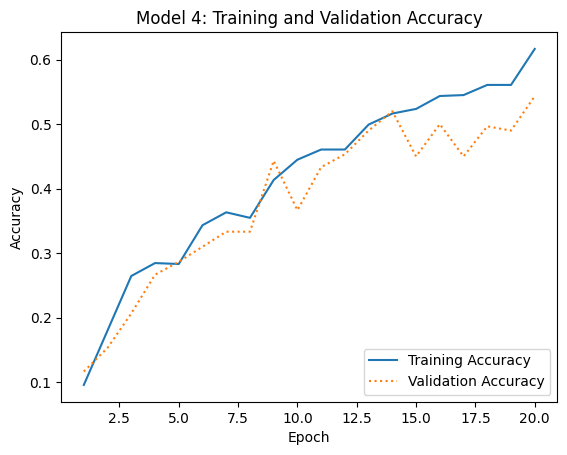

In [14]:
# Model 4: Additional Dense layer
model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))

model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])
hist = model.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)
display_results(hist, "Model 4")

Epoch 1/20
22/22 [==============================] - 35s 2s/step - loss: 3.3648 - accuracy: 0.1159 - val_loss: 2.3476 - val_accuracy: 0.1233
Epoch 2/20
22/22 [==============================] - 33s 1s/step - loss: 2.2974 - accuracy: 0.1359 - val_loss: 2.1802 - val_accuracy: 0.1600
Epoch 3/20
22/22 [==============================] - 33s 1s/step - loss: 2.0925 - accuracy: 0.2189 - val_loss: 2.0804 - val_accuracy: 0.2433
Epoch 4/20
22/22 [==============================] - 33s 2s/step - loss: 1.9820 - accuracy: 0.2847 - val_loss: 1.9620 - val_accuracy: 0.2933
Epoch 5/20
22/22 [==============================] - 32s 1s/step - loss: 1.8313 - accuracy: 0.3405 - val_loss: 1.8433 - val_accuracy: 0.3200
Epoch 6/20
22/22 [==============================] - 32s 1s/step - loss: 1.7551 - accuracy: 0.3505 - val_loss: 1.8505 - val_accuracy: 0.3133
Epoch 7/20
22/22 [==============================] - 32s 1s/step - loss: 1.6413 - accuracy: 0.3634 - val_loss: 1.6683 - val_accuracy: 0.3867
Epoch 8/20
22/22 [==

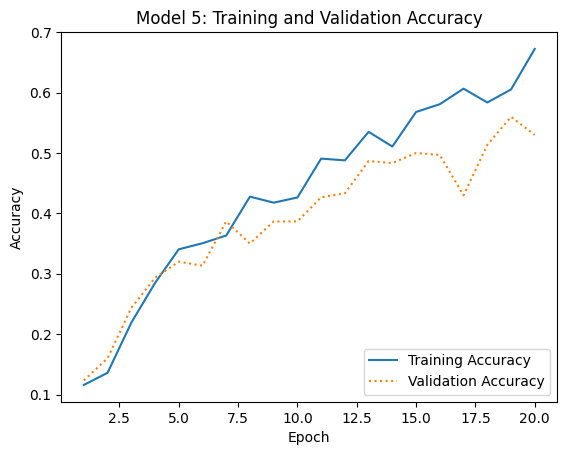

In [15]:
# Model 5: Change layer parameters to 128

model2 = Sequential()
model2.add(Conv2D(8, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))
model2.add(Conv2D(128, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((4,4), padding= 'same'))

model2.add(Flatten())
model2.add(Dense(128, activation= 'relu'))
model2.add(Dense(64, activation= 'relu'))
model2.add(Dense(10, activation= 'softmax'))

model2.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])
hist = model2.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)
display_results(hist, "Model 5")

In [ ]:
# Model 6: Change conv layer parameter dimensions

model2 = Sequential()
model2.add(Conv2D(8, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model2.add(MaxPooling2D((2,2), padding= 'same'))
model2.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((2,2), padding= 'same'))
model2.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((2,2), padding= 'same'))
model2.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((2,2), padding= 'same'))
model2.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((2,2), padding= 'same'))
model2.add(Conv2D(128, (3,3), activation= 'relu', padding= 'same'))
model2.add(MaxPooling2D((2,2), padding= 'same'))

model2.add(Flatten())
model2.add(Dense(128, activation= 'relu'))
model2.add(Dense(64, activation= 'relu'))
model2.add(Dense(10, activation= 'softmax'))

model2.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])
hist = model2.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)
display_results(hist, "Model 6")

Epoch 1/20
22/22 [==============================] - 94s 2s/step - loss: 10.1752 - accuracy: 0.0930 - val_loss: 2.3651 - val_accuracy: 0.1300
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 2.2875 - accuracy: 0.1574 - val_loss: 2.2043 - val_accuracy: 0.2633
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 2.1394 - accuracy: 0.2318 - val_loss: 2.0437 - val_accuracy: 0.2533
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 2.0162 - accuracy: 0.2718 - val_loss: 1.9336 - val_accuracy: 0.2967
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 1.8535 - accuracy: 0.3233 - val_loss: 1.8116 - val_accuracy: 0.3000
Epoch 6/20
22/22 [==============================] - 34s 2s/step - loss: 1.7358 - accuracy: 0.3662 - val_loss: 1.8921 - val_accuracy: 0.3433
Epoch 7/20
22/22 [==============================] - 36s 2s/step - loss: 1.6665 - accuracy: 0.3906 - val_loss: 1.7335 - val_accuracy: 0.3167
Epoch 8/20
22/22 [=